# **Dog vs Cat Classication**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/



# **Import Data**

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.05G/1.06G [00:05<00:00, 182MB/s]
100% 1.06G/1.06G [00:06<00:00, 190MB/s]


In [ ]:
!kaggle datasets download -d arpitjain007/dog-vs-cat-fastai



 99% 1.58G/1.60G [00:23<00:00, 77.4MB/s]
100% 1.60G/1.60G [00:23<00:00, 71.5MB/s]


In [ ]:
import zipfile

zip_data = zipfile.ZipFile('/content/dogs-vs-cats.zip')
zip_data.extractall('/content')
zip_data.close()


In [ ]:
import zipfile

zip_data = zipfile.ZipFile('/content/dog-vs-cat-fastai.zip')
zip_data.extractall('/content')
zip_data.close()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
import matplotlib.pyplot as plt
import cv2


array([[[178, 124,  64],
        [183, 131,  71],
        [193, 139,  84],
        ...,
        [ 17,  92, 130],
        [ 17,  92, 130],
        [ 17,  92, 130]],

       [[179, 125,  65],
        [185, 131,  71],
        [191, 137,  82],
        ...,
        [ 17,  92, 130],
        [ 17,  92, 130],
        [ 17,  92, 130]],

       [[179, 123,  64],
        [183, 129,  69],
        [187, 133,  78],
        ...,
        [ 17,  92, 130],
        [ 18,  93, 131],
        [ 18,  93, 131]],

       ...,

       [[236, 165, 102],
        [235, 164, 101],
        [236, 165, 102],
        ...,
        [199, 149, 103],
        [199, 149, 103],
        [199, 149, 103]],

       [[234, 163, 100],
        [234, 163,  99],
        [234, 163, 100],
        ...,
        [195, 143,  97],
        [193, 143,  97],
        [196, 144,  98]],

       [[238, 167, 103],
        [238, 168, 101],
        [237, 166, 102],
        ...,
        [197, 142,  97],
        [195, 143,  97],
        [196, 141,  96]]], dtype=uint8)
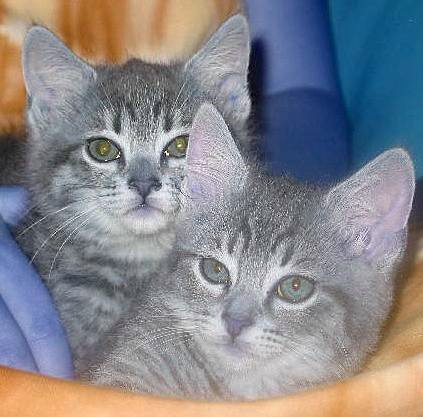

In [ ]:
img = cv2.imread('/content/test/cats/cat.10021.jpg')
img


In [ ]:
import tensorflow as tf



# Generate augmented training data
train_ds1 = tf.keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels="inferred",
    label_mode="int",
    batch_size=64,
    image_size=(256, 256),

)

train_ds2 = tf.keras.utils.image_dataset_from_directory(
    directory='/content/dogscats/train',
    labels="inferred",
    label_mode="int",
    batch_size=64,
    image_size=(256, 256),

)


# Load test data without augmentation
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels="inferred",
    label_mode="int",
    batch_size=64,
    image_size=(256, 256)
)

train_ds = train_ds1.concatenate(train_ds2)
# Print the total number of data points in train_ds
total_train_samples = len(train_ds)
print(f"Total training samples in train_ds: {total_train_samples}")
# Debugging Output
print(len(train_ds1))
print(len(train_ds2))
print(len(test_ds ))

Found 20000 files belonging to 2 classes.
Found 23000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Total training samples in train_ds: 673
313
360
79


In [ ]:
train_ds = train_ds1.concatenate(train_ds2)
# Print the total number of data points in train_ds
total_train_samples = len(train_ds)
print(f"Total training samples in train_ds: {total_train_samples}")


Total training samples in train_ds: 673


In [ ]:
# Normalization
def scale_down_px(image, label):
  image = tf.cast(image/255, tf.float32)

  return image, label




In [ ]:
train_ds = train_ds.map(scale_down_px)
test_ds = test_ds.map(scale_down_px)



# **Model Training using pre-trained VGG16 model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
# Resize images to (224, 224) before passing them to the model
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (256, 256)), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Load pre-trained VGG16 model without top layers (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the pre-trained VGG16 base
model = Sequential([
    base_model,
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
tensorboard_callback = TensorBoard(log_dir='./logs')
callbacks = [early_stopping, tensorboard_callback]
# Train the model
history = model.fit(train_ds, epochs=20, validation_data=test_ds, callbacks=callbacks)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
673/673 [==============================] - 347s 486ms/step - loss: 0.3481 - accuracy: 0.9187 - val_loss: 0.1111 - val_accuracy: 0.9540
Epoch 2/20
673/673 [==============================] - 314s 465ms/step - loss: 0.0926 - accuracy: 0.9635 - val_loss: 0.0671 - val_accuracy: 0.9758
Epoch 3/20
673/673 [==============================] - 314s 465ms/step - loss: 0.0523 - accuracy: 0.9792 - val_loss: 0.0936 - val_accuracy: 0.9680
Epoch 4/20
673/673 [==============================] - 314s 466ms/step - loss: 0.0409 - accuracy: 0.9840 - val_loss: 0.0450 - val_accuracy: 0.9852
Epoch 5/20
673/673 [==============================] - 303s 449ms/step - loss: 0.0283 - accuracy: 0.9886 - val_loss: 0.0496 - val_accuracy: 0.9850
Epoch 6/20
673/673 [==============================] - 301s 447ms/step - loss: 0.0220 - accuracy: 0.9921 - val_loss: 0.0408 - val_accuracy: 0.9882
Epoch 7/20
673/673 [==============================] - 313s 

# **Training/Validation Accuracy Graph**

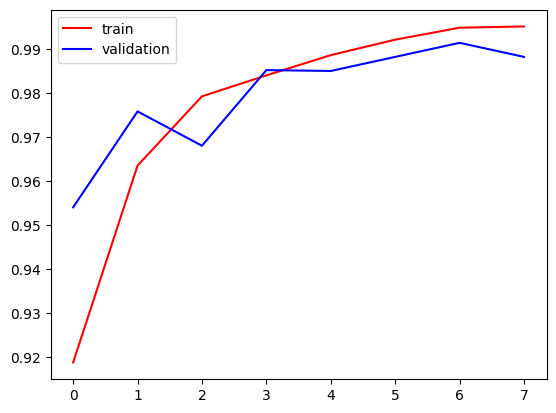

In [ ]:
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()


# Training/Validation Loss **Graph**

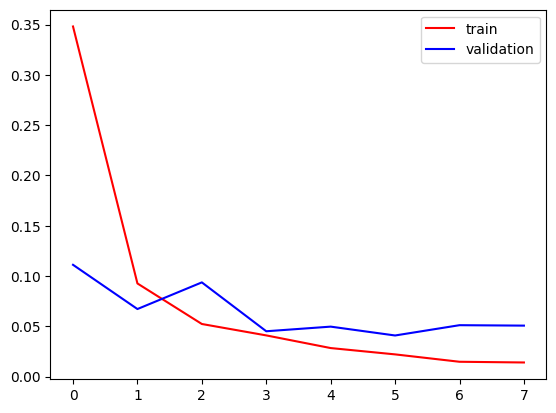

In [ ]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

# **Testing The Model**

1/1 [==============================] - 1s 1s/step
This is a cat.


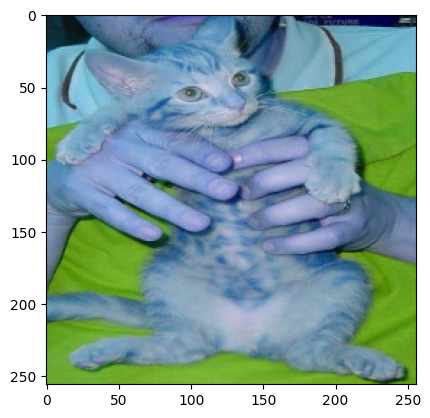

In [ ]:
#Using Test image from dataset
import cv2
import numpy as np

# Load the image you want to predict
image = cv2.imread('/content/dogscats/dogscats/valid/cats/cat.1001.jpg')
image = cv2.resize(image, (256, 256))  # Resize the image to match the model's input size
image = image / 255.0  # Normalize the image

# Use the model to make a prediction
predictions = model.predict(np.expand_dims(image, axis=0))

# Apply the threshold
if predictions[0] < 0.5:
    print("This is a cat.")
else:
    print("This is a dog.")
plt.imshow(image)

# **Testing The Model on online images**

1/1 [==============================] - 0s 18ms/step
This is a dog.


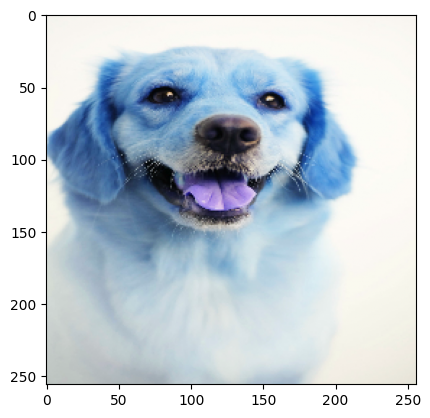

In [ ]:
import requests
import cv2
import numpy as np

# Define the URL of the image you want to predict
image_url = 'https://images.unsplash.com/photo-1598875706250-21faaf804361?q=80&w=1921&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'
# Download the image from the URL
response = requests.get(image_url)
image_data = np.frombuffer(response.content, np.uint8)
image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)
image = cv2.resize(image, (256, 256))  # Resize the image to match the model's input size
image = image / 255.0  # Normalize the image

# Use the model to make a prediction
predictions = model.predict(np.expand_dims(image, axis=0))

# Apply the threshold
if predictions[0] < 0.5:
    print("This is a cat.")
else:
    print("This is a dog.")
plt.imshow(image)

In [ ]:
import requests
import cv2
import numpy as np

# Define the URL of the image you want to predict
image_url = 'https://media.istockphoto.com/id/483799085/photo/lazy-fat-cat-sleeping-on-the-couch.webp?b=1&s=170667a&w=0&k=20&c=8Io_RSyyI9JB16FtFwKRpjPpv9EeNkrbOMcLAmLSNYI='
# Download the image from the URL
response = requests.get(image_url)
image_data = np.frombuffer(response.content, np.uint8)
image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)
image = cv2.resize(image, (256, 256))  # Resize the image to match the model's input size
image = image / 255.0  # Normalize the image

# Use the model to make a prediction
predictions = model.predict(np.expand_dims(image, axis=0))

# Apply the threshold
if predictions[0] < 0.5:
    print("This is a cat.")
else:
    print("This is a dog.")
plt.imshow(image)

# **Saving  Trained Model**

In [ ]:
from tensorflow.keras.models import load_model



# Save the model to disk
model.save("dog_vs_cat_model.h5")

print("Model saved successfully.")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


In [ ]:
from tensorflow.keras.models import load_model

# Assuming you have already trained your model and stored it in the 'model' variable
# For example:
# model = ... (your trained model)

# Save the model to the desktop in HDF5 format
model.save("/content/drive/MyDrive/Colab Notebooks/AI Models Save/dog_vs_cat_model2.hdf5")

print("Model saved successfully.")


Model saved successfully.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
